In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!cp 'drive/My Drive/image_arrays_train.zip' .

In [ ]:
#Extract
!unzip -q image_arrays_train.zip

In [ ]:
import pandas as pd
import gc
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler,LabelEncoder
import glob
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.layers import Dense,Conv2D,TimeDistributed,Flatten,Input,AvgPool2D,LSTM,LeakyReLU,Concatenate,Dropout,Embedding
from keras import Model

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns

In [ ]:
#Import du fichier de base train pour la récupération des IDs
train = pd.read_excel('/content/drive/MyDrive/train indivs.xlsx')

In [ ]:
train.shape

(2382, 2)

In [ ]:
def get_array(df, bands_of_interest=[]):
    # Check if 'Field_ID' is present in the DataFrame
    if 'Field_ID' not in df.columns:
        raise KeyError("Column 'Field_ID' not found in the DataFrame.")

    array = []

    # Filter only the 'Field_ID' values present in the DataFrame
    valid_field_ids = df['Field_ID'].tolist()

    for field_id in tqdm(valid_field_ids):
        fn = './image_arrays_train/' + field_id + '.npy'

        try:
            img = np.load(fn)[:,:5,:5]
            img = img.transpose((1, 2, 0))
            img = img.reshape(5, 5, 30, -1)

            # Get all band names
            all_band_names = ['S2_B{}'.format(i) for i in range(1, 13)]

            # Get the indices of bands to be included based on the bands_of_interest
            included_band_indices = [i for i, name in enumerate(all_band_names) if name in bands_of_interest]

            # Include specified bands
            img = img[:, :, included_band_indices, :]

            img = img.transpose((3, 0, 1, 2))
            img = img / np.max(img)
            img = img.astype('float16')
            array.append(img)
        except FileNotFoundError:
            # Handle the case where the file for the given 'Field_ID' is not found
            print(f"File not found for Field_ID: {field_id}")

    return np.stack(array)

In [ ]:
bands= ['S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B11','S2_B12']

In [ ]:
X_train = get_array(train, bands)

  0%|          | 0/2382 [00:00<?, ?it/s]

In [ ]:
X_train

array([[[[[1.9067e-01, 0.0000e+00, 3.7598e-01, ..., 0.0000e+00,
           1.7224e-01, 1.7566e-01],
          [1.9067e-01, 0.0000e+00, 3.7598e-01, ..., 0.0000e+00,
           1.7224e-01, 1.7566e-01],
          [1.9556e-01, 0.0000e+00, 3.6865e-01, ..., 0.0000e+00,
           1.7224e-01, 1.8591e-01],
          [1.9556e-01, 0.0000e+00, 3.6865e-01, ..., 0.0000e+00,
           1.7224e-01, 1.8591e-01],
          [1.7871e-01, 0.0000e+00, 3.6279e-01, ..., 0.0000e+00,
           1.7224e-01, 1.5955e-01]],

         [[2.0227e-01, 0.0000e+00, 3.4448e-01, ..., 0.0000e+00,
           1.7114e-01, 1.8579e-01],
          [2.0227e-01, 0.0000e+00, 3.4448e-01, ..., 0.0000e+00,
           1.7114e-01, 1.8579e-01],
          [2.0862e-01, 0.0000e+00, 3.5278e-01, ..., 0.0000e+00,
           1.7114e-01, 1.9263e-01],
          [2.0862e-01, 0.0000e+00, 3.5278e-01, ..., 0.0000e+00,
           1.7114e-01, 1.9263e-01],
          [1.8494e-01, 0.0000e+00, 3.4814e-01, ..., 0.0000e+00,
           1.7114e-01, 1.7444e-01]

In [ ]:
y_train = train.Yield.values

In [ ]:
y_train

array([1.391, 1.391, 2.087, ..., 5.727, 3.97 , 2.457])

In [ ]:
test = pd.read_excel('/content/drive/MyDrive/test indivs.xlsx')

In [ ]:
X_test = get_array(test, bands)

  0%|          | 0/563 [00:00<?, ?it/s]

In [ ]:
X_test

array([[[[[2.9688e-01, 0.0000e+00, 8.6865e-01, ..., 0.0000e+00,
           3.1299e-01, 3.8770e-01],
          [2.8149e-01, 0.0000e+00, 8.2422e-01, ..., 0.0000e+00,
           3.1299e-01, 3.7280e-01],
          [2.8149e-01, 0.0000e+00, 8.2422e-01, ..., 0.0000e+00,
           3.1299e-01, 3.7280e-01],
          [2.4622e-01, 0.0000e+00, 5.8594e-01, ..., 0.0000e+00,
           3.0005e-01, 3.3887e-01],
          [2.4622e-01, 0.0000e+00, 5.8594e-01, ..., 0.0000e+00,
           3.0005e-01, 3.3887e-01]],

         [[2.9688e-01, 0.0000e+00, 8.6865e-01, ..., 0.0000e+00,
           3.1299e-01, 3.8770e-01],
          [2.8149e-01, 0.0000e+00, 8.2422e-01, ..., 0.0000e+00,
           3.1299e-01, 3.7280e-01],
          [2.8149e-01, 0.0000e+00, 8.2422e-01, ..., 0.0000e+00,
           3.1299e-01, 3.7280e-01],
          [2.4622e-01, 0.0000e+00, 5.8594e-01, ..., 0.0000e+00,
           3.0005e-01, 3.3887e-01],
          [2.4622e-01, 0.0000e+00, 5.8594e-01, ..., 0.0000e+00,
           3.0005e-01, 3.3887e-01]

In [ ]:
y_test = test.Yield.values

In [ ]:
y_test

array([ 3.686,  5.657,  3.082,  2.707,  2.679,  4.317,  2.999,  4.199,
        3.505,  5.039,  2.52 ,  3.172,  2.353,  2.957,  3.269,  3.117,
        2.79 ,  4.859,  2.568,  0.986,  3.498,  2.638,  4.456,  4.165,
        5.706,  4.019,  3.547,  2.443,  4.315,  2.236,  3.419,  3.471,
        4.081,  0.458,  3.285,  2.582,  3.748,  3.16 ,  2.582,  4.104,
        2.356,  4.908,  3.165,  3.658,  4.54 ,  3.929,  4.817,  2.423,
        4.019,  6.636,  4.901,  6.247,  2.867,  3.103,  7.851,  3.464,
        1.902,  3.408,  6.504, 10.127,  9.274,  3.061,  2.45 ,  7.559,
        5.442,  5.102,  9.319, 10.127,  4.484,  3.79 ,  6.58 ,  7.913,
        6.386,  3.748,  6.969,  3.29 ,  8.468,  5.74 ,  2.443,  6.039,
        3.734,  2.423,  3.318,  2.777,  5.4  ,  3.249,  5.97 ,  2.992,
        4.012,  2.86 ,  3.242,  4.269,  3.144,  3.651,  4.262,  7.573,
        4.72 ,  4.241,  2.783,  1.902,  4.269,  3.977,  2.617,  2.679,
        3.79 ,  4.692,  2.95 ,  3.859,  5.116,  1.826,  5.227,  4.602,
      

In [ ]:
X_train.shape

(2382, 12, 5, 5, 9)

In [ ]:
y_train.shape

(2382,)

In [ ]:
X_test.shape

(563, 12, 5, 5, 9)

In [ ]:
y_test.shape

(563,)

**LSTM with hyperparameters tuning**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Reshape the input data to be 3D (samples, timesteps, features)
X_trainlstm = X_train.reshape((X_train.shape[0], X_train.shape[1], -1))
X_testlstm=X_test.reshape((X_test.shape[0], X_test.shape[1], -1))

# Define the LSTM model
def create_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_trainlstm.shape[1], X_trainlstm.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Define hyperparameters for grid search
param_grid = {
    'units': [50, 100, 150],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

# Perform grid search
best_mse = float('inf')
best_params = {}


for units in param_grid['units']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            model = create_lstm_model(units=units)
            model.fit(X_trainlstm, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred = model.predict(X_testlstm)
            mse = mean_squared_error(y_test, y_pred)

            if mse < best_mse:
                best_mse = mse
                best_params = {'units': units, 'batch_size': batch_size, 'epochs': epochs}

# Train the final model with the best hyperparameters
final_model = create_lstm_model(units=best_params['units'])
final_model.fit(X_trainlstm, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2)

18/18 [==============================] - 1s 9ms/step
Epoch 1/20
38/38 - 3s - loss: 3.5536 - 3s/epoch - 77ms/step
Epoch 2/20
38/38 - 1s - loss: 2.8107 - 1s/epoch - 27ms/step
Epoch 3/20
38/38 - 1s - loss: 2.7887 - 1s/epoch - 28ms/step
Epoch 4/20
38/38 - 1s - loss: 2.7546 - 1s/epoch - 29ms/step
Epoch 5/20
38/38 - 2s - loss: 2.7495 - 2s/epoch - 48ms/step
Epoch 6/20
38/38 - 2s - loss: 2.7214 - 2s/epoch - 52ms/step
Epoch 7/20
38/38 - 2s - loss: 2.7248 - 2s/epoch - 57ms/step
Epoch 8/20
38/38 - 2s - loss: 2.7045 - 2s/epoch - 50ms/step
Epoch 9/20
38/38 - 2s - loss: 2.6898 - 2s/epoch - 43ms/step
Epoch 10/20
38/38 - 1s - loss: 2.7117 - 1s/epoch - 28ms/step
Epoch 11/20
38/38 - 1s - loss: 2.7112 - 1s/epoch - 28ms/step
Epoch 12/20
38/38 - 1s - loss: 2.6639 - 1s/epoch - 27ms/step
Epoch 13/20
38/38 - 1s - loss: 2.6076 - 1s/epoch - 27ms/step
Epoch 14/20
38/38 - 1s - loss: 2.6164 - 1s/epoch - 28ms/step
Epoch 15/20
38/38 - 1s - loss: 2.4991 - 1s/epoch - 30ms/step
Epoch 16/20
38/38 - 2s - loss: 2.4978 - 2

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# Evaluate the model on the test set
y_predlstm = final_model.predict(X_testlstm)

# Calculate the mean squared error
maelstm = mean_absolute_error(y_test, y_predlstm)
maelstm


18/18 [==============================] - 1s 9ms/step


1.3393505383943791

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predlstm)

2.9683472468909016

In [ ]:
rmse= np.sqrt(mean_squared_error(y_test, y_predlstm))
rmse

1.7228892149209425

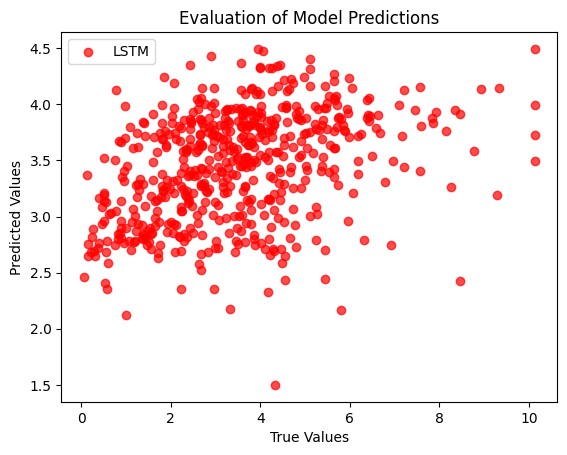

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predlstm, label='LSTM', alpha=0.7, color='r')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of Model Predictions')
plt.legend()

plt.show()

**DNN with hyperparameters tuning**

In [ ]:
!pip install scikeras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

class KerasRegressorDNN(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam', neurons=[64, 32], dropout_rates=[0.2, 0.1], epochs=10, batch_size=32, verbose=0):
        self.optimizer = optimizer
        self.neurons = neurons
        self.dropout_rates = dropout_rates
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = Sequential()


        X_flat = X.reshape((X.shape[0], -1))

        # Input layer
        self.model.add(Dense(self.neurons[0], activation='relu', input_shape=(X_flat.shape[1],)))

        # Hidden layers
        for i in range(1, len(self.neurons)):
            self.model.add(Dropout(self.dropout_rates[i-1]))
            self.model.add(Dense(self.neurons[i], activation='relu'))

        # Output layer
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss='mean_squared_error', optimizer=self.optimizer)

        self.model.fit(X_flat, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        # Reshape input data before prediction
        X_flat = X.reshape((X.shape[0], -1))
        return self.model.predict(X_flat)


def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    return -mse


param_dist = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'neurons': [[32, 16], [64, 32], [128, 64]],
    'dropout_rates': [[0.2, 0.1], [0.3, 0.2], [0.1, 0.0]]
}

# RandomizedSearchCV
random_search_dnn = RandomizedSearchCV(estimator=KerasRegressorDNN(), param_distributions=param_dist, n_iter=10, scoring=make_scorer(custom_scorer, greater_is_better=False), cv=3)
random_search_dnn_result = random_search_dnn.fit(X_train, y_train)


print("Best: %f using %s" % (-random_search_dnn_result.best_score_, random_search_dnn_result.best_params_))


25/25 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: custom_scorer() missing 1 required positional argument: 'y'

  warnings.warn(


25/25 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best: nan using {'optimizer': 'rmsprop', 'neurons': [128, 64], 'dropout_rates': [0.1, 0.0]}


In [ ]:

print("Best: %f using %s" % (-random_search_dnn_result.best_score_, random_search_dnn_result.best_params_))


best_params = random_search_dnn_result.best_params_


Best: nan using {'optimizer': 'rmsprop', 'neurons': [128, 64], 'dropout_rates': [0.1, 0.0]}


In [ ]:
model_dnn = KerasRegressorDNN(**best_params)
model_dnn.fit(X_train, y_train)

KerasRegressorDNN(dropout_rates=[0.1, 0.0], neurons=[128, 64],
                  optimizer='rmsprop')

In [ ]:
y_preddn = model_dnn.predict(X_test)
mdnn = mean_absolute_error(y_test, y_preddn)
mdnn

18/18 [==============================] - 0s 4ms/step


1.6735765209689233

In [ ]:
mean_squared_error(y_test, y_preddn)

4.716195162542463

In [ ]:
rmse2= np.sqrt(mean_squared_error(y_test, y_preddn))
rmse2

2.171680262502393

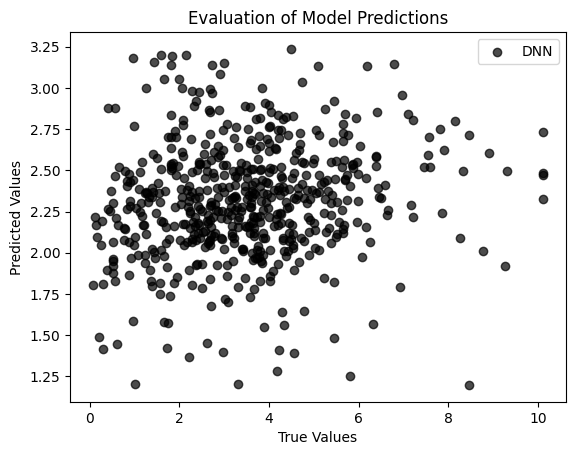

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_preddn, label='DNN', alpha=0.7, color='black')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of Model Predictions')
plt.legend()

plt.show()

**3D CNN with hyperparameters tuning**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam', neurons=64, filters=32, kernel_size=(3, 3, 3), pool_size=(2, 2, 2), dropout_rate=0.0, epochs=10, batch_size=32, verbose=0):
        self.optimizer = optimizer
        self.neurons = neurons
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = Sequential()
        self.model.add(Conv3D(self.filters, kernel_size=self.kernel_size, activation='relu', input_shape=(12, 5, 5, 9)))
        self.model.add(MaxPooling3D(pool_size=self.pool_size))
        self.model.add(Flatten())
        self.model.add(Dense(self.neurons, activation='relu'))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss='mean_squared_error', optimizer=self.optimizer)

        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)


def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    return -mse




param_dist = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'neurons': randint(32, 128),
    'filters': randint(16, 64),
    'kernel_size': [(3, 3, 3), (4, 4, 4), (5, 5, 5)],
    'dropout_rate': uniform(0, 0.2)
}


random_search = RandomizedSearchCV(estimator=KerasRegressorWrapper(), param_distributions=param_dist, n_iter=10, scoring=make_scorer(custom_scorer, greater_is_better=False), cv=3)
random_search_result = random_search.fit(X_train, y_train)


print("Best: %f using %s" % (-random_search_result.best_score_, random_search_result.best_params_))


25/25 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: custom_scorer() missing 1 required positional argument: 'y'

  warnings.warn(


25/25 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-39-34a209303bd7>", line 25, in fit
    self.model.add(MaxPooling3D(pool_size=self.pool_size))
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-pac

Best: nan using {'dropout_rate': 0.19889550071274664, 'filters': 19, 'kernel_size': (3, 3, 3), 'neurons': 127, 'optimizer': 'adam'}


In [ ]:
best_params = random_search_result.best_params_

final_model = KerasRegressorWrapper(**best_params)
final_model.fit(X_train, y_train)

KerasRegressorWrapper(dropout_rate=0.19889550071274664, filters=19, neurons=127)

In [ ]:
y_pred3d = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred3d)
test_mae

18/18 [==============================] - 0s 4ms/step


1.3691003290450805

In [ ]:
mean_squared_error(y_test, y_pred3d )

3.1493085716772184

In [ ]:
rmse3= np.sqrt(mean_squared_error(y_test, y_pred3d ))
rmse3

1.77462913637673

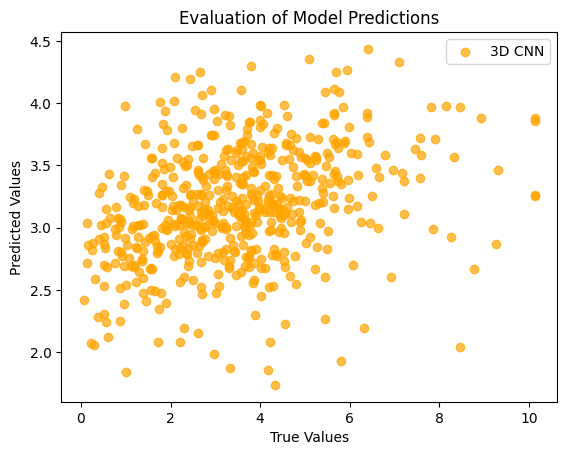

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred3d, label='3D CNN', alpha=0.7, color='orange')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of Model Predictions')
plt.legend()

plt.show()